In [2]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
import os
import glob
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [3]:
states_daily = pd.read_csv("covid19_data/states-daily.csv")
states_dailyNY = states_daily[states_daily['state']=="NY"]

In [4]:
states_dailyNY

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked
37,20200323,NY,20875.0,57414.0,NaN,2635.0,114.0,78289,2020-03-23T20:00:00Z
93,20200322,NY,15168.0,46233.0,NaN,1974.0,114.0,61401,2020-03-22T20:00:00Z
149,20200321,NY,10356.0,35081.0,NaN,1603.0,44.0,45437,2020-03-21T20:00:00Z
205,20200320,NY,7102.0,25325.0,NaN,NaN,35.0,32427,2020-03-20T20:00:00Z
261,20200319,NY,4152.0,18132.0,NaN,NaN,12.0,22284,2020-03-19T20:00:00Z
314,20200318,NY,2382.0,12215.0,NaN,NaN,12.0,14597,2020-03-18T20:00:00Z
370,20200317,NY,1700.0,5506.0,NaN,NaN,7.0,7206,2020-03-17T20:00:00Z
426,20200316,NY,950.0,4543.0,NaN,NaN,7.0,5493,2020-03-16T20:00:00Z
482,20200315,NY,729.0,4543.0,NaN,NaN,3.0,5272,2020-03-15T20:00:00Z
533,20200314,NY,524.0,2779.0,NaN,NaN,NaN,3303,2020-03-14T20:00:00Z


In [5]:
#some cleanup

# turn date into datetime object
states_dailyNY.loc[:,"date"] = pd.to_datetime(states_dailyNY["date"],format='%Y%m%d', errors='ignore')
# remove NaN from pending
states_dailyNY.loc[:,"pending"] = states_dailyNY["pending"].fillna(0)
# subtract pending from total since they seem to reappear
states_dailyNY.loc[:,'total_corr'] = states_dailyNY['total']-states_dailyNY['pending']
# calculate days from start of the epidemic
states_dailyNY.loc[:,'days'] = pd.to_timedelta(states_dailyNY.date).dt.days
states_dailyNY.loc[:,'days'] = states_dailyNY.loc[:,'days'] - states_dailyNY['days'].iloc[-1]

/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will rai

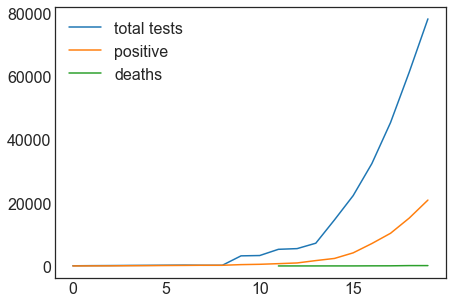

In [6]:
plt.figure(figsize=(7,5))
plt.plot(states_dailyNY.days,states_dailyNY['total_corr'],label="total tests")
plt.plot(states_dailyNY.days,states_dailyNY['positive'],label="positive")
plt.plot(states_dailyNY.days,states_dailyNY['death'],label="deaths")
plt.legend()

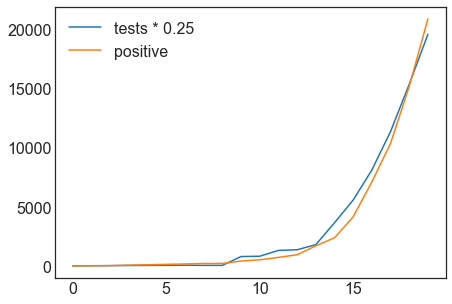

In [7]:
# one question that I had is whether the exponential comes from the increased number of tests or
# because the disease spreads exponentially
# It seems that the data is consistent with the population being 25% infected by the virus and that
# 25% of the people that are tested will be positive.
plt.figure(figsize=(7,5))
plt.plot(states_dailyNY.days,states_dailyNY['total_corr']*.25,label="tests * 0.25")
plt.plot(states_dailyNY.days,states_dailyNY['positive'],label="positive")
plt.legend()

In [8]:
# get NY county data from the John's Hopkins dataset
daily_list = glob.glob("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/*.csv")
daily_list.sort()
daily_list = daily_list[42:]
for file in daily_list:
    date = file[-14:-4]
    print(date, file)
    daily = pd.read_csv(file)
    print(daily.columns.values)
    if "Province/State" in daily.columns.values:
        print("Province/State")
        daily.loc[:,"Province/State"] = daily["Province/State"].fillna("")
        daily = daily[daily['Province/State'].str.contains('NY')]
        display(daily)
    if "Province_State" in daily.columns.values:
        print("Province_State")
        daily.loc[:,"Province_State"] = daily["Province_State"].fillna("")
        daily = daily[daily['Province_State'].str.contains('New York')]
        display(daily)


03-04-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-04-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
74,"Westchester County, NY",US,2020-03-04T21:23:10,10,0,0,41.1220,-73.7949
148,"New York City, NY",US,2020-03-02T01:53:03,1,0,0,40.7128,-74.0060


03-05-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-05-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
64,"Westchester County, NY",US,2020-03-05T21:33:03,18,0,0,41.1220,-73.7949
97,"New York City, NY",US,2020-03-05T21:03:13,4,0,0,40.7128,-74.0060
159,"Queens County, NY",US,2020-03-05T21:43:02,1,0,0,40.7282,-73.7949


03-06-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-06-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
67,"Westchester County, NY",US,2020-03-06T15:43:03,19,0,0,41.1220,-73.7949
74,"New York County, NY",US,2020-03-06T19:13:40,16,0,0,40.7128,-74.0060
178,"Nassau County, NY",US,2020-03-06T14:43:15,1,0,0,40.6546,-73.5594


03-07-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-07-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
50,"Westchester County, NY",US,2020-03-07T18:23:05,57,0,0,41.1220,-73.7949
86,"New York County, NY",US,2020-03-07T18:23:05,11,0,0,40.7128,-74.0060
114,"Nassau County, NY",US,2020-03-07T00:03:28,4,0,0,40.6546,-73.5594
146,"Rockland County, NY",US,2020-03-07T16:43:02,2,0,0,41.1489,-73.9830
150,"Saratoga County, NY",US,2020-03-07T18:23:05,2,0,0,43.0324,-73.9360


03-08-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-08-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
46,"Westchester County, NY",US,2020-03-08T18:03:07,83,0,0,41.1220,-73.7949
92,"New York County, NY",US,2020-03-08T04:13:22,12,0,0,40.7128,-74.0060
120,"Nassau County, NY",US,2020-03-08T16:03:05,5,0,0,40.6546,-73.5594
167,"Rockland County, NY",US,2020-03-07T16:43:02,2,0,0,41.1489,-73.9830
171,"Saratoga County, NY",US,2020-03-07T18:23:05,2,0,0,43.0324,-73.9360
236,"Suffolk County, NY",US,2020-03-08T16:03:05,1,0,0,40.9849,-72.6151
238,"Ulster County, NY",US,2020-03-08T16:23:07,1,0,0,41.8586,-74.3118


03-09-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-09-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
43,"Westchester County, NY",US,2020-03-09T17:13:16,98,0,0,41.1220,-73.7949
80,"New York County, NY",US,2020-03-09T17:13:16,19,0,0,40.7128,-74.0060
84,"Nassau County, NY",US,2020-03-09T17:13:14,17,0,0,40.6546,-73.5594
137,"Rockland County, NY",US,2020-03-09T17:33:13,4,0,0,41.1489,-73.9830
181,"Saratoga County, NY",US,2020-03-07T18:23:05,2,0,0,43.0324,-73.9360
248,"Suffolk County, NY",US,2020-03-08T16:03:05,1,0,0,40.9849,-72.6151
250,"Ulster County, NY",US,2020-03-08T16:23:07,1,0,0,41.8586,-74.3118


03-10-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-10-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-11-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-11-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-12-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-12-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-13-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-13-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-14-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-14-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-15-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-15-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-16-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-16-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-17-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-17-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-18-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-18-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-19-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-19-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-20-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-20-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-21-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-21-2020.csv
['Province/State' 'Country/Region' 'Last Update' 'Confirmed' 'Deaths'
 'Recovered' 'Latitude' 'Longitude']
Province/State


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude


03-22-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-22-2020.csv
['FIPS' 'Admin2' 'Province_State' 'Country_Region' 'Last_Update' 'Lat'
 'Long_' 'Confirmed' 'Deaths' 'Recovered' 'Active' 'Combined_Key']
Province_State


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
2353,36085.0,Richmond,New York,US,3/22/20 23:45,40.585822,-74.148086,0,0,0,0,"Richmond, New York, US"
2354,36097.0,Schuyler,New York,US,3/22/20 23:45,42.391840,-76.877330,0,0,0,0,"Schuyler, New York, US"
2355,36099.0,Seneca,New York,US,3/22/20 23:45,42.780810,-76.824971,0,0,0,0,"Seneca, New York, US"
2356,36089.0,St. Lawrence,New York,US,3/22/20 23:45,44.497618,-75.065500,0,0,0,0,"St. Lawrence, New York, US"


03-23-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-23-2020.csv
['FIPS' 'Admin2' 'Province_State' 'Country_Region' 'Last_Update' 'Lat'
 'Long_' 'Confirmed' 'Deaths' 'Recovered' 'Active' 'Combined_Key']
Province_State


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
27,36001.0,Albany,New York,US,2020-03-23 23:19:34,42.600603,-73.977239,127,0,0,0,"Albany, New York, US"
42,36003.0,Allegany,New York,US,2020-03-23 23:19:34,42.257484,-78.027505,2,0,0,0,"Allegany, New York, US"
276,36005.0,Bronx,New York,US,2020-03-23 23:19:34,40.852093,-73.862828,0,0,0,0,"Bronx, New York, US"
281,36007.0,Broome,New York,US,2020-03-23 23:19:34,42.159032,-75.813261,3,1,0,0,"Broome, New York, US"
433,36009.0,Cattaraugus,New York,US,2020-03-23 23:19:34,42.247782,-78.679231,0,0,0,0,"Cattaraugus, New York, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
2997,36115.0,Washington,New York,US,2020-03-23 23:19:34,43.311538,-73.430434,1,0,0,0,"Washington, New York, US"
3027,36117.0,Wayne,New York,US,2020-03-23 23:19:34,43.154944,-77.029765,3,0,0,0,"Wayne, New York, US"
3052,36119.0,Westchester,New York,US,2020-03-23 23:19:34,41.162784,-73.757417,2894,0,0,0,"Westchester, New York, US"
3140,36121.0,Wyoming,New York,US,2020-03-23 23:19:34,42.701451,-78.221996,2,1,0,0,"Wyoming, New York, US"


03-24-2020 COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-24-2020.csv
['FIPS' 'Admin2' 'Province_State' 'Country_Region' 'Last_Update' 'Lat'
 'Long_' 'Confirmed' 'Deaths' 'Recovered' 'Active' 'Combined_Key']
Province_State


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
27,36001.0,Albany,New York,US,2020-03-24 23:37:31,42.600603,-73.977239,146,0,0,0,"Albany, New York, US"
42,36003.0,Allegany,New York,US,2020-03-24 23:37:31,42.257484,-78.027505,2,0,0,0,"Allegany, New York, US"
276,36005.0,Bronx,New York,US,2020-03-24 23:37:31,40.852093,-73.862828,0,0,0,0,"Bronx, New York, US"
281,36007.0,Broome,New York,US,2020-03-24 23:37:31,42.159032,-75.813261,9,1,0,0,"Broome, New York, US"
433,36009.0,Cattaraugus,New York,US,2020-03-24 23:37:31,42.247782,-78.679231,0,0,0,0,"Cattaraugus, New York, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,36115.0,Washington,New York,US,2020-03-24 23:37:31,43.311538,-73.430434,3,0,0,0,"Washington, New York, US"
3025,36117.0,Wayne,New York,US,2020-03-24 23:37:31,43.154944,-77.029765,6,0,0,0,"Wayne, New York, US"
3050,36119.0,Westchester,New York,US,2020-03-24 23:37:31,41.162784,-73.757417,3891,1,0,0,"Westchester, New York, US"
3138,36121.0,Wyoming,New York,US,2020-03-24 23:37:31,42.701451,-78.221996,4,1,0,0,"Wyoming, New York, US"
